# Prediciting Particle Transport by Ocean and Wind Currents at Sea Level

Sometime about 500 years ago, famed explorer Ferdinand Magellan said: "The sea is dangerous and its storms terrible, but these obstacles have never been sufficient reason to remain ashore." (Watkins, 2010). This quote is mainly about respecting the power of the sea, then with unknown powers. Although the power of the sea never should be underestimated, we are at this day and age able to measure and even predict its power in ocean and wind currents through numerical simulations. These simulations have mulitple usages, and was for example used to caluclate the trajectory of oilspill after the explosion on the oil platform Deepwater Horizon in 2010. In the future these simulations will remain highly relevant due to the oceans increasing amount of plastics. This report will use recorded data from the Norwegian Meteorological Institute of ocean and wind currents to implement these simulations to predict the trajectory of plastics at sea level as Lagrangian particles along the Norwegian coast.

<hr>

In [33]:
# Import necessary libraries

%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from time import time

import xarray as xr
from scipy.interpolate import RectBivariateSpline

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

**(1a)** For these simulations, it is useful to start off with a simple case without the recorded data. This will be done by simulating a velocity field of wind and ocean currents in the $xy$-plane for $x \in \left[0,2\right]$, $y \in \left[0,1\right]$, and then consider particles $\textbf{r}$ moving in this field. These particles' trajectories will be dependent on the ODE $$ \dot{\textbf{r}} = [v_x(\textbf{r}, t), v_y(\textbf{r}, t)],$$ with $v_x$ and $v_y$ as the velocity field components in the $x$ and $y$ directions. The expressions for this specific example are defined below.

Heun's method, a second-order explicit method, will be implemented to solve this ODE. As will be seen later, the advantage of this ODE-solver is that the time interval can be adjusted such that it coincides with discrete time intervals. This is due to the method only using integer multiples of the time interval $h$. By setting $h$ to be the sampling interval of any given data, interpolation in the time dimension is redundant.

Below are defined necessary constants and functions for solving this ODE. This will be implemented to handle $N$ particles for later use.

In [34]:
#Define necessary constants
A = 0.1
epsilon = 0.25
omega = 1


# Define given functions for simplicty in the ODE
def a(t: float):
    return epsilon * np.sin(omega * t)

def b(t:float):
    return 1 - 2 * epsilon * np.sin(omega * t)

def f_a(x:float, t:float):
    return a(t) * x**2 + b(t) * x

def fDelX(x:float, t:float):
    return 2 * a(t) * x + b(t)

def vX(x:float, y:float, t:float):
    return -np.pi * A * np.sin(np.pi * f_a(x, t)) * np.cos(np.pi * y)

def vY(x:float, y:float, t:float):
    return np.pi * A * np.cos(np.pi * f_a(x, t)) * np.sin(np.pi * y) * fDelX(x, t)

# Final ODE, using the above defined functions
def ODE(coords:np.ndarray, t:float):
    xs = coords[0,:]
    ys = coords[1,:]
    return np.array([vX(xs, ys, t), vY(xs, ys, t)])

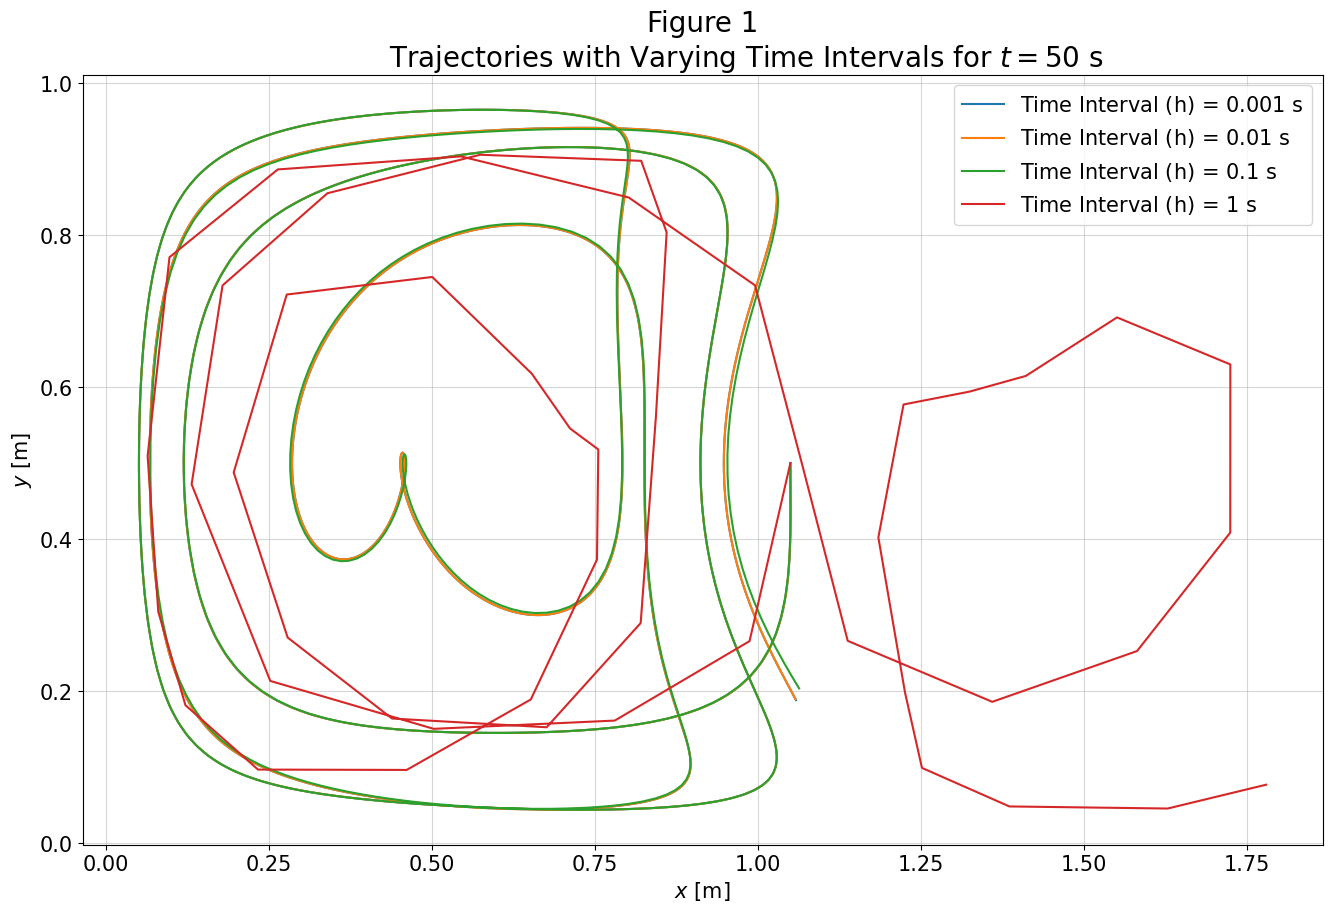

In [35]:
# Implement Heun's method for solving an ODE
def Heun(h:float, time:float, initPos:np.ndarray, f:callable):
    """Inputs a time interval, amount of time, initial position of the particles, an ODE,
    and returns an array with the coordinates of the particle trajectories.
    Dimensions of initPos: (2, n), where n is the number of particles.
    Dimensions of output: (2, n, t//h), where n is the number of particles and t//h is the number of time steps."""
    
    t = np.arange(0, time, h)

    #Create an empty array of coordinates, and initialise the first position
    coordArr = np.zeros((initPos.shape[0],initPos.shape[1],len(t)))
    coordArr[:,:,0] = initPos

    for i in range(1, len(t)):
        # Perform a step of the Heun algorithm 
        formerCoord = coordArr[:,:,i-1]
        ti = t[i-1]

        k1 = f(formerCoord, ti)
        tempCoord = formerCoord + k1*h
        k2 = f(tempCoord, ti + h)

        coordArr[:,:,i] = formerCoord +h/2*(k1 + k2)

    return coordArr

# Plot the trajectories of one particle with varying time intervals
plt.figure(figsize=(16, 10))
plt.title("""Figure 1
          Trajectories with Varying Time Intervals for $t = 50$ s""", fontsize=20)
plt.xlabel("$x$ [m]", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("$y$ [m]", fontsize=15)
plt.yticks(fontsize=15)

# Set initial position
pos0 = np.zeros((2,1))
pos0[0:,] = 1.05
pos0[1:,] = 0.5

hVals = [0.001, 0.01, 0.1, 1]

for h in hVals:
     trajectory = Heun(h, 50, pos0, ODE)
     plt.plot(trajectory[0,0,:], trajectory[1,0,:], label = f"Time Interval (h) = ${h}$ s")
     plt.grid(alpha=0.5)
     plt.legend(fontsize=15)

**Figure 1**: Plot of trajectories of a particle moving for $50$ s, using Heuns method in a simulated vector field with varying time intervals.

From **Figure 1** it can be argued that a time interval of about $0.1$ s is a sufficiently short time interval. Generally in stepwise ODE-solvers, the smaller the time interval, the more accurate the simulation is. However, it is also relevant to reduce computing time, and therefore use a larger time interval that reduces the number of iterations. The trajectories in **Figure 1** for $h = 0.001$ s, $h = 0.01$ s and $h = 0.1$ s all closely overlap, and it is therefore reasonable to use a time interval of $0.1$ s going forward.

The accuracy can of course be related to the simulation time $t$, and it is therefore relevant to investigate if this time interval is as useful for a larger $t$, as done below.

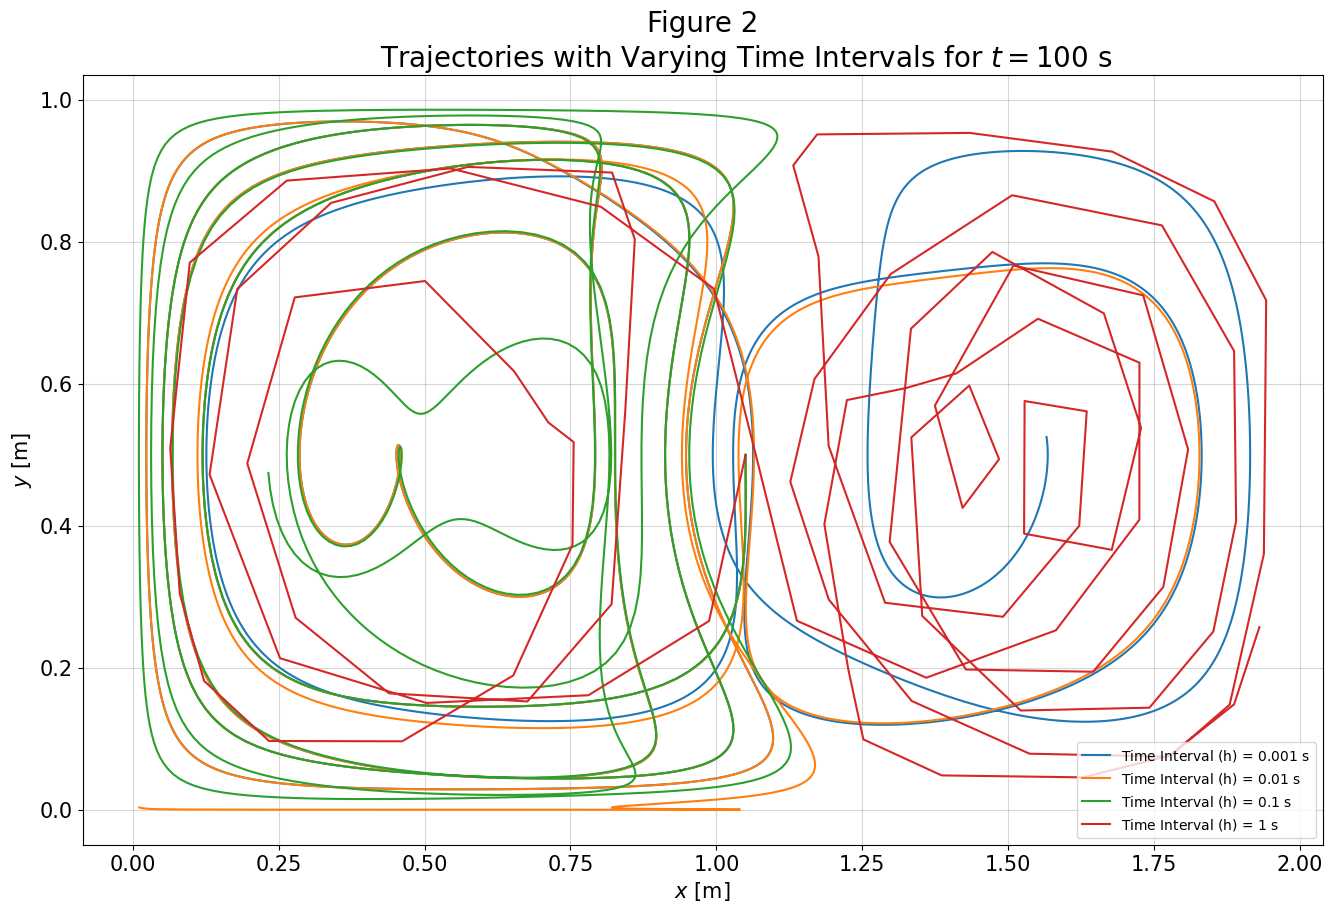

In [36]:
plt.figure(figsize=(16, 10))
plt.title("""Figure 2
          Trajectories with Varying Time Intervals for $t = 100$ s""", fontsize=20)
plt.xlabel("$x$ [m]", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("$y$ [m]", fontsize=15)
plt.yticks(fontsize=15)

for h in hVals:
     trajectory = Heun(h, 100, pos0, ODE)
     plt.plot(trajectory[0,0,:], trajectory[1,0,:], label = f"Time Interval (h) = ${h}$ s")
     plt.grid(alpha=0.5)
     plt.legend()

**Figure 2**: Plot of trajectories of a particle moving for $100$ s, using Heuns method in a simulated vector field with varying time intervals.

From **Figure 2** it can be argued that a time interval of $0.1$ s might not be sufficiently small enough. As argued above, most ODE-solvers are more accurate the smaller the time interval, and in the figure above the simulation with $h = 0.1$ s does not exhibit a similar trajectory as the simulations with smaller time intervals. It is therefore more reasonable to use a smaller time interval. Thus, $h = 0.01$ s will be used going forward.

It can also be noted that the larger time interval $h = 1$ s exhibit a similar trajectory to the ones for smaller values of $h$ in "exiting" the first circle, but this is more likely due to a too big of a time interval, making its trajectory more random. Elsewise, its trajectory does not resemble the others'.

**(1b)** It is now natural to observe multiple particles' trajectories in the same plot, given different inital positions. These positions may be totally randomized, but it is interesting to observe how particles starting close to each other behave differently. This is done below.

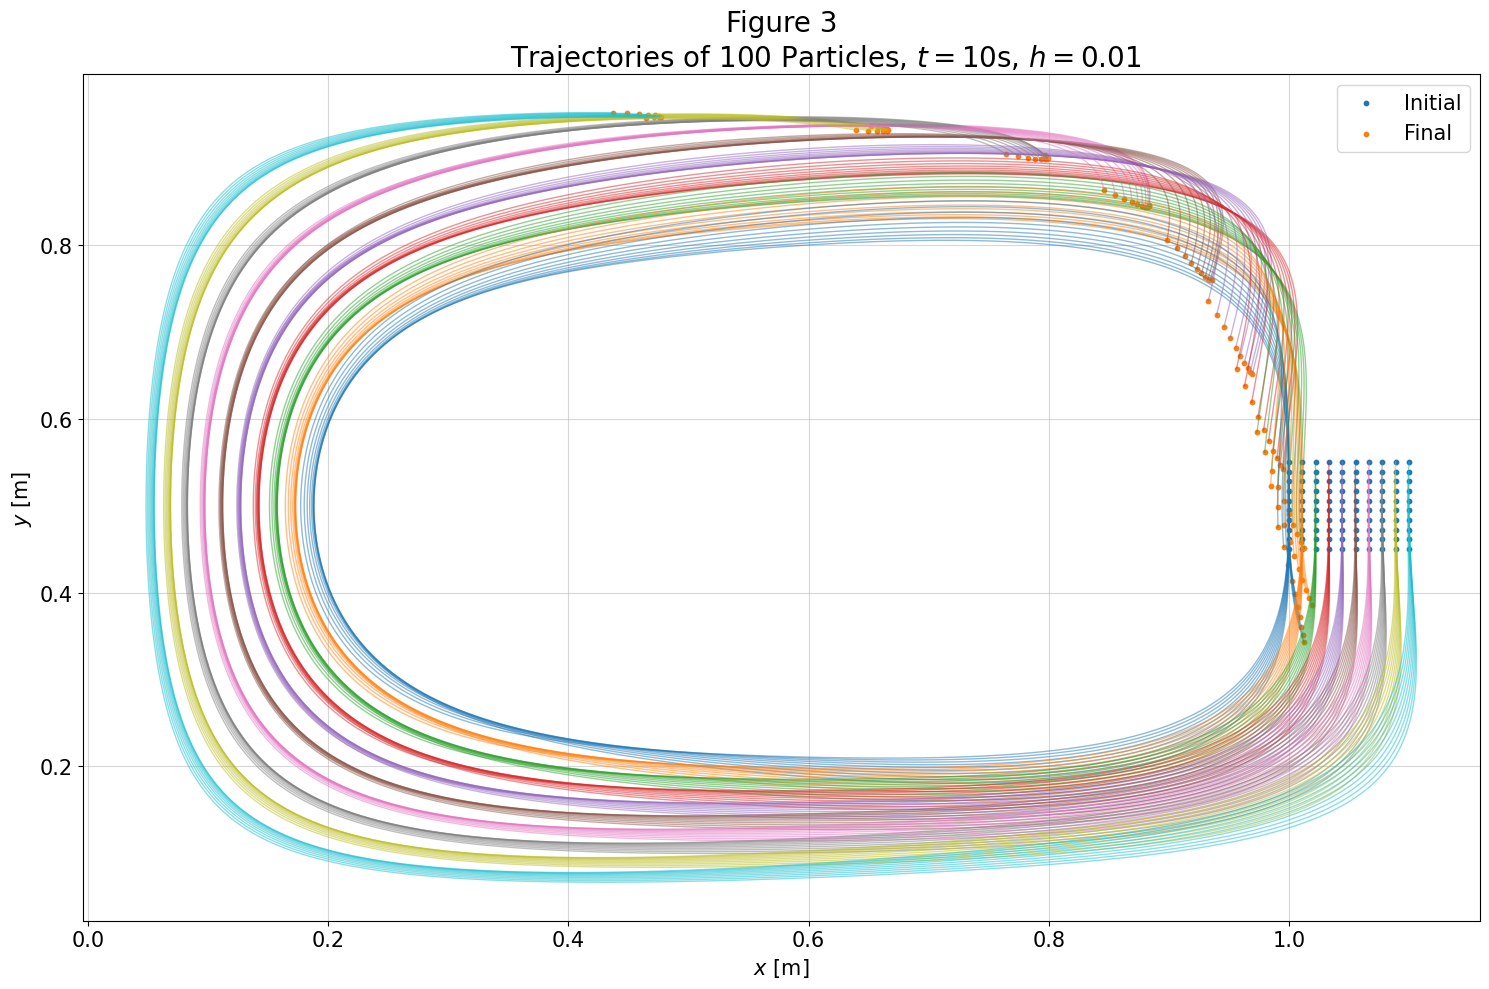

In [37]:
h = 0.01
Np = 100
rows, columns = int(np.sqrt(Np)), int(np.sqrt(Np))

# Initialize the grid of particles
xArr = np.linspace(1, 1.1, rows)
yArr = np.linspace(0.45, 0.55, rows)
X, Y = np.meshgrid(xArr, yArr)
initPositions = np.vstack([X.flatten(), Y.flatten()])

B = Heun(h, 10, initPositions, ODE)

# Plot the trajectories of Np particles in a grid of different initial positions around the inital position from 1a)
plt.figure(figsize=(15,10))
ax= plt.axes()

ax.scatter(initPositions[0,:], initPositions[1,:], s=10, label='Initial')
for i in range(Np):
    ax.plot(B[0,i,:],B[1,i,:], lw=1.0, alpha=0.5)
ax.scatter(B[0,:,-1], B[1,:,-1], s=10, label='Final')

ax.set_xlabel('$x$ [m]', fontsize=15)
ax.set_ylabel('$y$ [m]', fontsize=15)
ax.legend(fontsize=15)

plt.title("""Figure 3
          Trajectories of $100$ Particles, $t = 10$s, $h = 0.01$""", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15) 
plt.grid(alpha=0.5)
plt.tight_layout()

**Figure 3**: Plot of the trajectories of $100$ particles moving for $10$ s, using Heuns method in a simulated vector field.

As in **(1a)**, the particles exhibit traits of moving as if caught in an ocean or wind current. It is however apparent that although particles initially placed close to each other exhibit similar trajectories, they might end up quite far away from each other. This can be seen by the difference in distance between the innermost (closest to origo) and the outermost particles before and after the simulation, where they go from a distance of $0.1$ m, to about $0.8$ m apart.

**(1c)** To ensure that `Heun` is sufficiently efficient when presented with larger inputs, it is useful to perform a runtime analysis. This will be done by running the algorithm for an exponentially increasing number of particles.

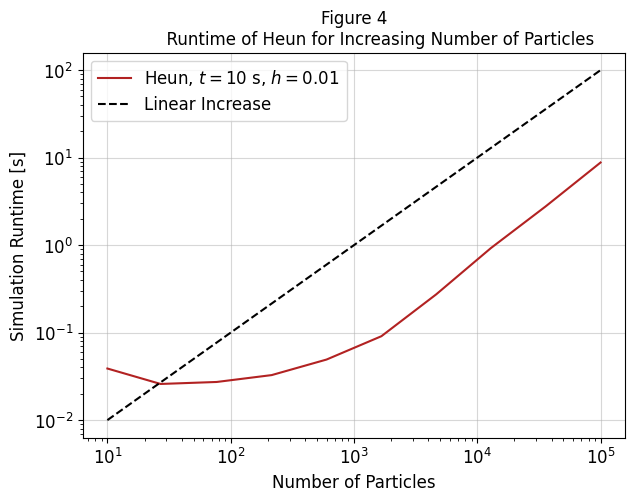

In [38]:
# Test implementation by measuring runtime for different numbers of particles, and plot runtime as function of N_p
NpArr = np.logspace(1,5,10, dtype=int)
t = np.zeros(len(NpArr))

for i, Np in enumerate(NpArr):
    pos0 = np.zeros((2,Np))
    pos0[0:,] = np.random.rand(Np)
    pos0[1:,] = np.random.rand(Np)

    t0 = time()
    trajectory = Heun(0.01, 10, pos0, ODE)
    t1 = time()
    t[i] = t1 - t0

# Plot the runtimes as a function of number of particles
plt.figure(figsize=(7,5))
plt.title("""Figure 4
          Runtime of Heun for Increasing Number of Particles""")
plt.loglog(NpArr, t, label="Heun, $t = 10$ s, $h = 0.01$", color='firebrick')
plt.loglog(NpArr, NpArr/1000, linestyle="--", label="Linear Increase", color='black')
plt.xlabel("Number of Particles", fontsize=12)
plt.ylabel("Simulation Runtime [s]", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.show()

**Figure 4**: Runtime of `Heun` for an increasing number of particles, compared to a linear line.

As $N_p$ increases, the runtime increases similarly to the straight line. Therefore, it is reasonable to hypothesize an asymptotic runtime of $\mathcal{O}(n)$. However, when $N_p \in [10^1,10^3]$, the runtime seems to be $\mathcal{O}(1)$. This is because the implementation has some overhead, which dominate over the work done for each particle for smaller values of $N_p$.

**(2a)** The real-life data from the NorKyst800m model provided by the Norwegian Meteorological Institute is sampled in time intervals of $1$ h and has a datapoint for each $800$ m. To account for simulated particles being in between these discrete points, interpolation is used to evaluate values for any given position. A class implementing the interpolation is given below. The class also includes a function `on_land`, which determines whether a particle is on land or not. (This code is given in advance, and is merely pasted to the following cell)

In [39]:
#################################################
#### Convenience class for reading datafiles ####
#################################################

class Interpolator():
    def __init__(self, dataset, fw = 0.03):
        # xarray dataset object
        self.dataset = dataset
        # Windage factor
        self.fw = fw
        # Extract timestamps as number of seconds after the start of the file
        # Saves a bit of bother with dealing with np.datetime objects elsewhere
        self.times = np.array([(t - d.time[0])/np.timedelta64(1, 's') for t in d.time[:]], dtype=np.float64)
        self.depth = np.array(self.dataset.h)
        
    def get_interpolators(self, X, it):
        # Add a buffer of cells around the extent of the particle cloud
        buf  = 10
        # Find extent of particle cloud in terms of indices
        imax = np.searchsorted(self.dataset.X, np.amax(X[0,:])) + buf
        imin = np.searchsorted(self.dataset.X, np.amin(X[0,:])) - buf
        jmax = np.searchsorted(self.dataset.Y, np.amax(X[1,:])) + buf
        jmin = np.searchsorted(self.dataset.Y, np.amin(X[1,:])) - buf
        # Take out subset of array, to pass to
        # interpolation object
        # Fill NaN values (land cells) with 0, otherwise
        # interpolation won't work
        u_current = self.dataset.u[it, 0, jmin:jmax, imin:imax].T.fillna(0.0)
        v_current = self.dataset.v[it, 0, jmin:jmax, imin:imax].T.fillna(0.0)
        u_wind    = self.dataset.Uwind[it, jmin:jmax, imin:imax].T.fillna(0.0)
        v_wind    = self.dataset.Vwind[it, jmin:jmax, imin:imax].T.fillna(0.0)
        # RectBivariateSpline essentially returns a function,
        # which can be called to get value at arbitrary position
        fu_current = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], u_current)
        fv_current = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], v_current)
        fu_wind    = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], u_wind)
        fv_wind    = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], v_wind)
        return fu_current, fv_current, fu_wind, fv_wind
    
    def get_time_index(self, t):
        # Get index of largest timestamp smaller than (or equal to) t
        return np.searchsorted(self.times, t, side='right') - 1
    
    def on_land(self, X):
        # Find indices for each particle
        ix_list = np.searchsorted(self.dataset.X, X[0,:])
        iy_list = np.searchsorted(self.dataset.Y, X[1,:])
        # Identify which particles are in cells with depth 5
        # (which for some reason is the smallest depth)
        return np.array([self.depth[iy,ix] == 5.0 for ix, iy in zip(ix_list, iy_list)])

    def __call__(self, X, t):
        # get index of current time in dataset
        it = self.get_time_index(t)
        # get interpolating functions,
        # covering the extent of the particle
        fu_current, fv_current, fu_wind, fv_wind = self.get_interpolators(X, it)
        
        # Evaluate velocity at position(x[:], y[:])
        dx = fu_current(X[0,:], X[1,:], grid = False) + self.fw*fu_wind(X[0,:], X[1,:], grid = False)
        dy = fv_current(X[0,:], X[1,:], grid = False) + self.fw*fv_wind(X[0,:], X[1,:], grid = False)
        return np.array([dx, dy])

Before plotting on a map, a verification that the dynamic works is preferable. Therefore, a plot directly in the $xy$-plane is performed below.

In [40]:
# Update the file path to where you put the downloaded file
d  = xr.open_dataset('data/NorKyst-800m.nc')
# Initialise the interpolator object with the data
f  = Interpolator(dataset = d, fw =0.03)



# Parameters for normal distribution
meanX = 790000
meanY = 490000
standardDev = 10000

Np = 1000

# Create initial positions for the particles
X = np.zeros((2, Np))
X[0,:] = np.random.normal(loc = meanX, scale = standardDev, size = Np)
X[1,:] = np.random.normal(loc = meanY, scale = standardDev, size = Np)


# Run the simulation
E = Heun(3600,3600*5*24,X, f)

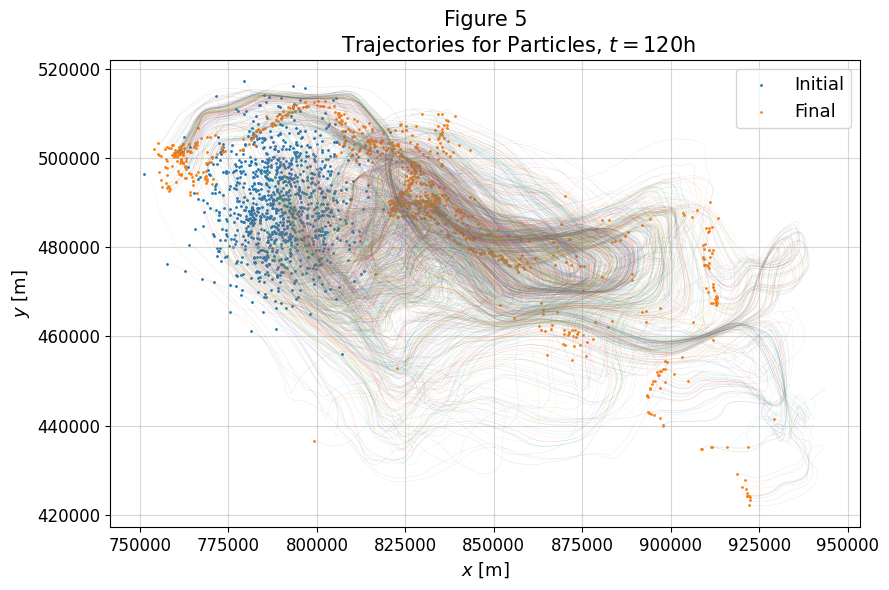

In [41]:
#Plot in the xy-plane

fig = plt.figure(figsize=(9,6))
ax= plt.axes()

ax.scatter(X[0,:], X[1,:], s=1, label='Initial')
for i in range(Np):
    ax.plot(E[0,i,:],E[1,i,:], lw=0.1, alpha=0.5)
ax.scatter(E[0,:,-1], E[1,:,-1], s=1, label='Final')

ax.set_xlabel('$x$ [m]', fontsize=13)
ax.set_ylabel('$y$ [m]', fontsize=13)
ax.legend(fontsize=13)
ax.tick_params(axis='both', which='major', labelsize=10)
plt.title("""Figure 5
          Trajectories for Particles, $t=120$h""", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()

**Figure 5**: A plot of $N_p = 1000$ particles placed approximately off the coast of Trøndelag directly in the $xy$-coordinates of the NorKyst800m model.

Note the placement of the particles, as these should be recognizable when compared to the same plot on a map. Also note that the $x$-coordinates are increasing towards north, while the $y$ coordinates are increasing towards west.

**(2b)** It is both far more interesting and useful to observe the positions of the particles on a map rather than on an empty grid. Since plotting on a map will be essential to the remainder of the report, this code is compiled into a function below. To facilitate for future needs, the function also returns the data points given by `Heun`, and allows for optional coloring of stranded particles. The function `HeunWithStop` is also implemented below. This function will be used later, but needs to be defined before `plottingFunction` to avoid errors. 

In [42]:
# Projection data for plotting
npstere = ccrs.Stereographic(
    central_latitude = 90,
    central_longitude = f.dataset.projection_stere.straight_vertical_longitude_from_pole,
    false_easting = f.dataset.projection_stere.false_easting,
    false_northing = f.dataset.projection_stere.false_northing,
    true_scale_latitude = f.dataset.projection_stere.standard_parallel,
)


def HeunWithStop(h, time, initPos, f):
    """Inputs a time interval, amount of time, initial position of the particle, an ODE,
    and returns an array with the coordinates of the particles trajectory"""

    t = np.arange(0, time, h)

    coordArr = np.zeros((initPos.shape[0],initPos.shape[1],len(t)))
    coordArr[:,:,0] = initPos

    for i in range(1, len(t)):
        formerCoord = coordArr[:,:,i-1]
        ti = t[i-1]

        k1 = f(formerCoord, ti)
        tempCoord = formerCoord + k1*h
        k2 = f(tempCoord, ti + h)

        # Check if the particle is on land or not. If so, the former coordinate is appended,
        # if not, the next coordinate is appended
        coordArr[:,:,i] = np.where(f.on_land(formerCoord),formerCoord,formerCoord +h/2*(k1 + k2))

    return coordArr


def plottingFunction(number: int, args: list[tuple], Np: int, h: float, time: float, standard_dev: float, mean_x:float, mean_y:float, title:str ="", ODE:callable =Heun):
    """Function to plot one or more simulations in the same plot.
    Inputs: number: Number of plots
    args: List of tuples containing the extent of the plot, in the form (s, e, b, t)
    Np: Number of particles
    h: Time interval
    time: End time
    standard_dev: Standard deviation of the normal distribution
    mean_x: Mean value of the normal distribution for x
    mean_y: Mean value of the normal distribution for y
    ODE: Function to use for the simulation, default is Heun, other option is HeunWithStop.
    
    Returns: E: np array of shape (number, 2, Np, time//h) with the coordinates of the particles at each time step.
    
    Side effects: Plots the trajectories of the particles in the given plots."""
        
    # Initialize arrays to store the initial positions and the trajectories
    S = np.zeros((number, 2, Np))
    E = np.zeros((number, 2, Np, time//h))

    # Fill start positions with random values from a normal distribution
    for i in range(number):
        S[i, 0, :] = np.random.normal(loc=mean_x[i], scale=standard_dev, size=Np)
        S[i, 1, :] = np.random.normal(loc=mean_y[i], scale=standard_dev, size=Np)

        # Run the simulation for each set of initial positions
        E[i] = ODE(h, time, S[i,:,:], f)

    # Define axes
    fig, axs = plt.subplots(1, number, figsize=(number*6, number*6), subplot_kw={'projection': ccrs.NorthPolarStereo()})

    # If only one plot is to be made, axs is not an array. Set it to an array to avoid issues plotting 1 plot
    if number == 1:
        axs = np.array([axs])
    
    # for each plot, set the extent, add features and plot the trajectories
    for ax, arg, S_j, E_j in zip(axs, args, S, E):
        s, e, b, t = arg
        ax.set_facecolor('#9CC4CF')
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', color='#a5a48b'))
        ax.scatter(S_j[0, :], S_j[1,:], s=0.7, transform=npstere, label='Initial', color='firebrick', alpha=0.7)

        for i in range(Np):
            ax.plot(E_j[0, i,:], E_j[1, i, :], transform=npstere, lw=0.1, alpha=0.3, color='black')
        
        # If the simulation is HeunWithStop, plot the particles that are stranded on land in a different color
        if (ODE==HeunWithStop):
            final_pos = E_j[:, :,-1]
            afloat = final_pos[:,f.on_land(final_pos)==False]
            stranded = final_pos[:,f.on_land(final_pos)==True]

            ax.scatter(afloat[0,:], afloat[1,:], s=1, transform=npstere, label='afloat', color='mediumseagreen')
            ax.scatter(stranded[0,:], stranded[1,:], s=1, transform=npstere, label='on land', color='blueviolet')
        else:
            ax.scatter(E_j[0, :, -1], E_j[1, :, -1], s=0.7, transform=npstere, label='Final', color='mediumseagreen')
        
        ax.set_extent((s, e, b, t))

        gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=.5, color='k', lw=.5)
        ax.legend()

    plt.title(title, fontsize=15)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    return E

To visualize how the ocean streams behave along the Norwegian coast, plots of particles placed at four different locations along the coast are created.

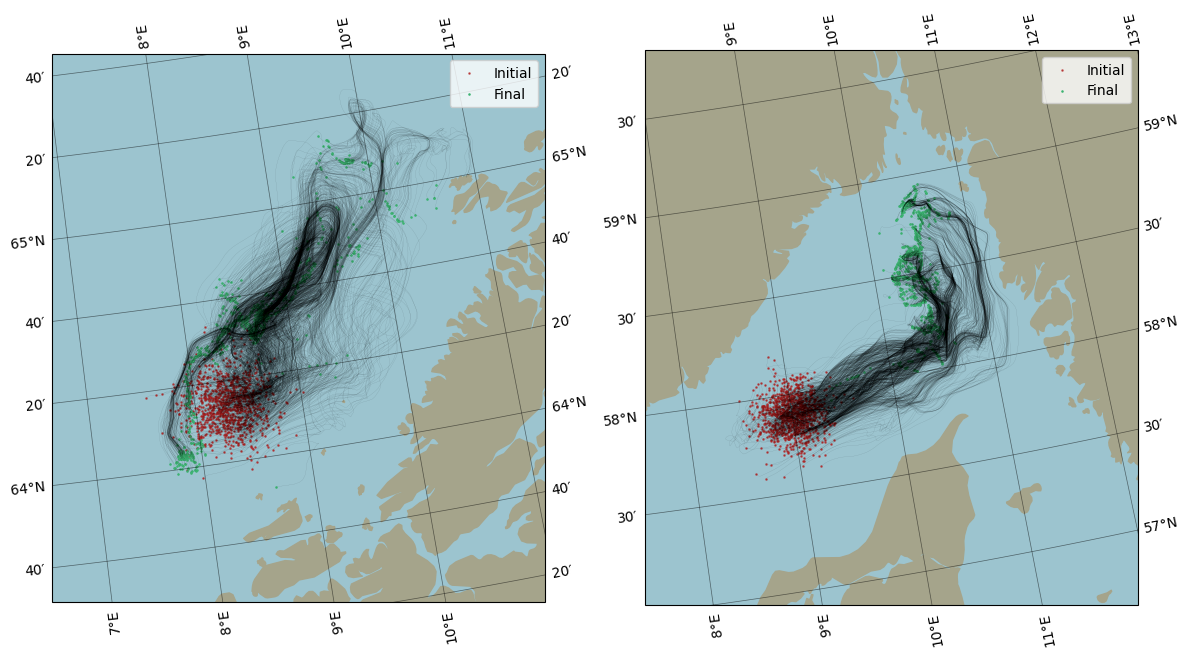

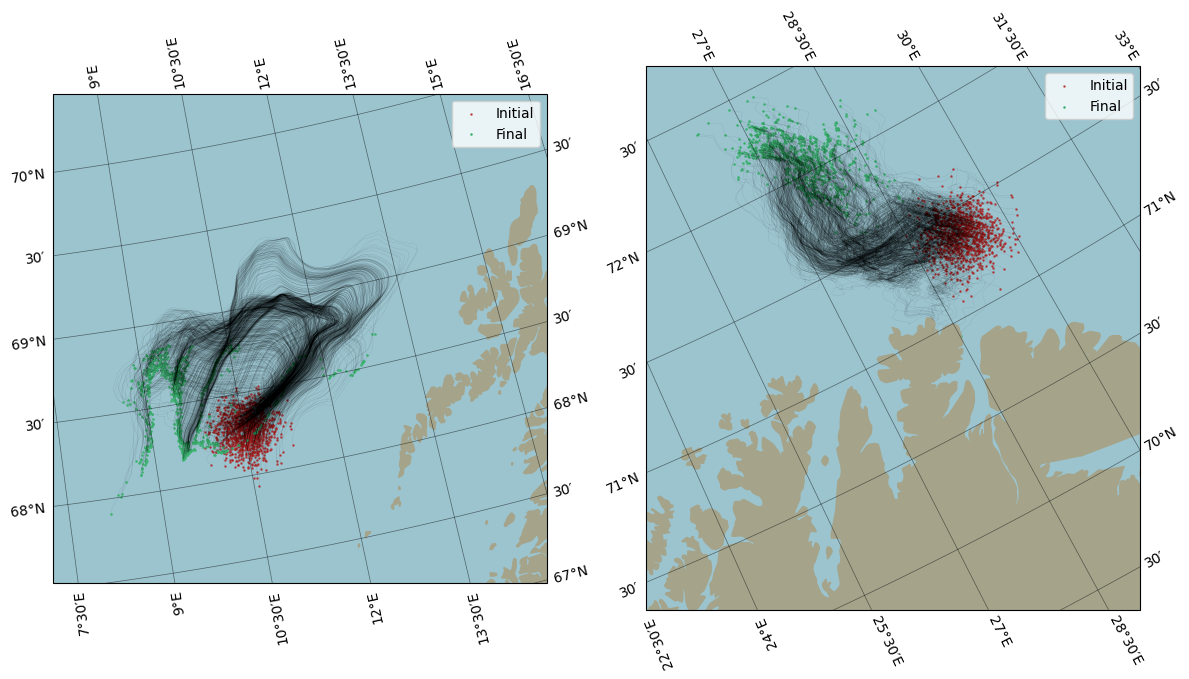

In [43]:
#Extents of the plots
args1 = ((7, 11, 63.5, 65.5), (8, 12, 59.5, 57))
args2 = ((8, 15, 67.5, 70), (25, 30, 70, 72.2))

#Normal distribution params
meanX1 = np.array([790000, 190000])
meanY1 = np.array([490000, 120000])

meanX2 = np.array([1220000, 1915000])
meanY2 = np.array([620000, 300000])

std = 10000

# Plotting two and two functions for visualization purposes
_ = plottingFunction(len(meanX1), args1, 1000, 3600, 3600*24*5, std, meanX1, meanY1)
_ = plottingFunction(len(meanX2), args2, 1000, 3600, 3600*24*5, std, meanX2, meanY2)

**Figure 6**: Particle movements when placed four different places along the Norwegian coast.

The top left image shows the same example as **Figure 5**, now projected onto a map. Note the resemblance. The other plots show selected arbitrary locations along the Norwegian coast. These trajectories differentiate as expected, as different locations naturally exhibit different wind and ocean currents.

Until now, the model has not taken into account that particles might end up hitting land. The function `on_land` from the `Interpolate` class will be used to modify `Heun`, such that this is accounted for. The modified implementation `HeunWithStop` is defined above, as mentioned in **2b)** to avoid errors. 

**(3a)** The modified method provides an opportunity to examine how many particles strand, as well as when and where they strand. To observe this, $1000$ particles are placed around a point off the coast of Western Norway and their trajectories are simulated below.

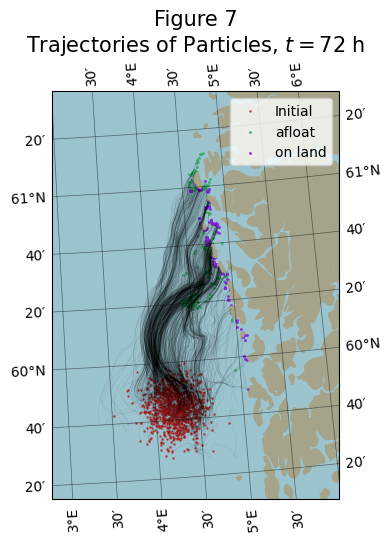

In [44]:
# Placement parameters
args = [(3, 6, 59.25, 61.5)]

mean_x = np.array([250000])
mean_y = np.array([460000])

# Store values for use in windage analysis. array access to get dimensions right
E = plottingFunction(1, args, 1000, 3600, 3600*24*3, 10000, mean_x, mean_y, 
                     """Figure 7
Trajectories of Particles, $t=72$ h""", HeunWithStop)[0]

**Figure 7**: Plot showing the movement of particles over 3 days, taking into account stranding of particles. The purple dots indicate stranded particles, while the green dots indicate particles still afloat.

Observing the particles' trajectories, it can be observed that quite a few particles have stranded, while other particles are close to the shore. This might suggest that a significant number of particles have stranded recently. To assess this hypothesis further, a plot of the percentage of stranded particles as a function of time is given below.

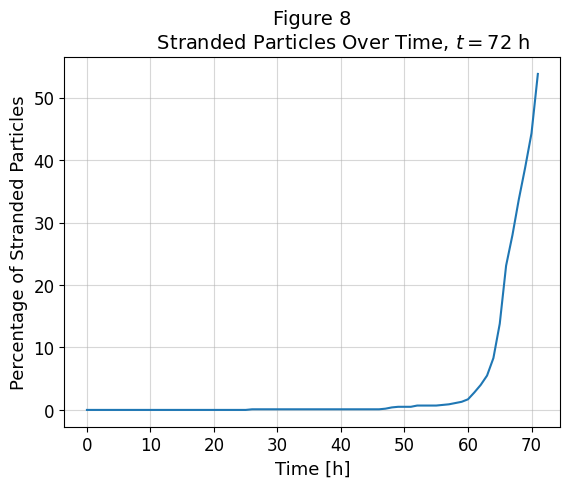

In [45]:
numStranded = np.zeros(E.shape[-1])
for i in range(E.shape[-1]):
    # Count the number of particles that are on land at each time step
    numStranded[i] = np.count_nonzero(f.on_land(E[:,:,i]))

plt.plot(numStranded/E.shape[1]*100)
plt.title("""Figure 8
          Stranded Particles Over Time, $t = 72$ h""", fontsize=14)
plt.xlabel('Time [h]', fontsize=13)
plt.xticks(fontsize=12)
plt.ylabel('Percentage of Stranded Particles', fontsize=13)
plt.yticks(fontsize=12)
plt.grid(alpha=0.5)
plt.show()

**Figure 8**: Plot showing the number of stranded particles as a function of time. 

It is observable that, as hypothesized above, that many particles strand shortly before the 3-day mark. This is of course dependent on the starting position and time, as ocean and wind currents differ.

**3b)** Another factor that affects whether or not the particles reach the shore, is the windage factor, $f_w$, of the particle. This factor relates wind contribution to the effect of the ocean currents. The larger $f_w$, the more impact the wind will have on the particle. Simulating particle drifts from the same initial positions while varying $f_w$ gives insight into what happens with increased contribution of the wind.

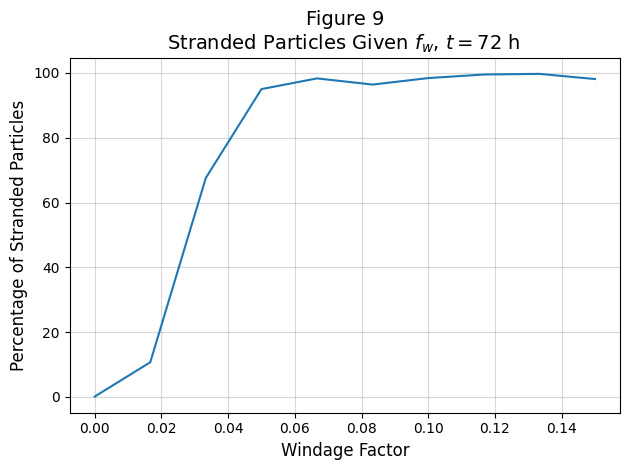

In [46]:
# Values for fw
fwArr = np.linspace(0, 0.15, 10)

#Preparing array for storing stranded particles
strandedArr = np.zeros(fwArr.shape)

# Create initial positions for the particles
X = np.zeros((2, 1000))
X[0,:] = np.random.normal(loc=mean_x[0], scale=10000, size=1000)
X[1,:] = np.random.normal(loc=mean_y[0], scale=10000, size=1000)

# Run the simulation for each windage factor
for i, fw in enumerate(fwArr):
    # Need to create an individual interpolator for each windage factor
    g = Interpolator(dataset = d, fw = fw)
    E = HeunWithStop(3600,3600*3*24,X, g)
    numStranded = np.count_nonzero(f.on_land(E[:,:,-1]))
    # Store result of simulation
    strandedArr[i] = numStranded

# Plot the results (percentage for stranded particles)
plt.plot(fwArr, strandedArr/X.shape[1]*100)
plt.title("""Figure 9
Stranded Particles Given $f_w$, $t=72$ h """, fontsize=14)
plt.xlabel('Windage Factor', fontsize=12)
plt.ylabel('Percentage of Stranded Particles', fontsize=12)
plt.tight_layout()
plt.grid(alpha=0.5)
plt.show()

**Figure 9**: The function of stranded particles with regards to the windage factor. 

As the windage factor increases, the number of stranded particles increases accordingly, with the largest increase when $f_w \approx 0.03$ Thus, it seems that the wind is pulling the particles towards the shore. It is again important to emphasize that this effect is still largely dependent on placement and time. Other simulation parameters might yield vastly different results. 

<hr>

## Conclusion

In this project, a numerical model for analyzing plastics moving in water, namely the Lagrangian particle model, was examined. Initially, a theoretical test case was used to establish the relation between simulation intervals and time steps. A method for plotting the particle trajectories was implemented, and an approximate runtime analyis was performed. Thereafter, real-world wind and waterstream data was used to examine movements along the Norwegian coast. Finally, shore contact was implemented, and analysis of how the wind affected the amount of particles reaching the shore was performed.

### Reference List

Watkins, S. (2010), *Forever Travels*, Mandinam Press